<a href="https://colab.research.google.com/github/junfrankohara/git-practice/blob/main/detect_goblet_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#セグメンテーションモデルのデモンストレーション


#セグメンテーションモデルのインストール
pip install segmentation_models_pytorch

In [2]:
#必要なファイルをアップロードする
pip install PyDrive googledrivedownloader

In [23]:
%cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [16]:
from PIL import Image
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io
from skimage.transform import rescale, resize
import glob
from tqdm import tqdm
import torch
import segmentation_models_pytorch as smp
Image.MAX_IMAGE_PIXELS = 1000000000
import google.colab
import googleapiclient.discovery
import googleapiclient.http
from pylab import rcParams
#見やすく大きく表示
rcParams['figure.figsize'] = 20,10

ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'


In [11]:
google.colab.drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [5]:
# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, #len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
best_model = torch.load('/content/gdrive/MyDrive/seg_model_ver3.pth')
goblet_model = torch.load('/content/gdrive/MyDrive/goblet_model_ver4.pth')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'segmentation_models_pytorch.fpn.model.FPN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'segmentation_models_pytorch.encoders.efficientnet.EfficientNetEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.padding.ZeroPad2d' has changed. you can retrieve the original source code by 

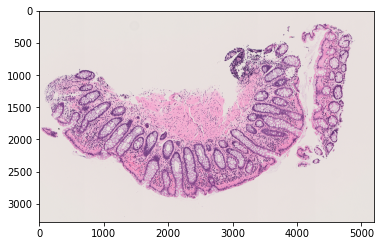

In [6]:
img_path='/content/gdrive/MyDrive/NH207954_5r.png'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

100%|██████████| 40/40 [00:02<00:00, 15.80it/s]


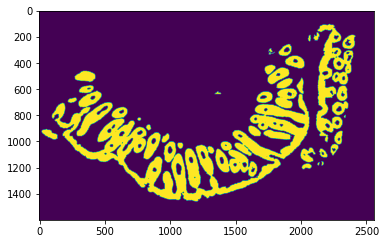

In [7]:
height = 320 #分割するタイルの高さ
width = 320 #分割するタイルの幅
img_half=resize(img, (img.shape[0] / 2, img.shape[1] / 2), anti_aliasing=True)
img_height= img_half.shape[0] #ロードした画像の高さ
img_width= img_half.shape[1] #}ロードした画像の幅
img_size=img_half.shape #ロードした画像のシェイプ
#画像を分割して一つのアレイcrop_arrayにまとめる
img_half=img_half[:int(img_size[0]/height)*height, :int(img_size[1]/width)*width,:]
crop_array=img_half.reshape(int(img_size[0]/height),height,int(img_size[1]/width),width, 3)
crop_array=crop_array.transpose([0,2,1,3,4])
crop_array=crop_array.reshape(-1,height,width,3)
lamina_list=[]
for rgb in tqdm(crop_array):
  # 前処理
    image = preprocessing_fn(rgb)
    image = image.transpose(2, 0, 1).astype('float32')
    image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predict = best_model(image)
    predict = predict.detach().cpu().numpy()[0]
    pr_lamina=predict[3,:,:]
    #確信度0.7以上を1とする
    pr_lamina = np.where(pr_lamina>0.7, 1, 0)
    lamina_list.append(pr_lamina)
lamina_arrays=np.stack(lamina_list)
#detect_arrayを並べて一つの画像に戻したdetect_img
re_x=lamina_arrays.reshape(int(img_size[0]/height),int(img_size[1]/width),height,width)
re_x=re_x.transpose([0,2,1,3])
detect_lamina=re_x.reshape(int(img_size[0]/height)*height, int(img_size[1]/width)*width).astype("uint8")
plt.imshow(detect_lamina)

100%|██████████| 160/160 [00:09<00:00, 16.01it/s]


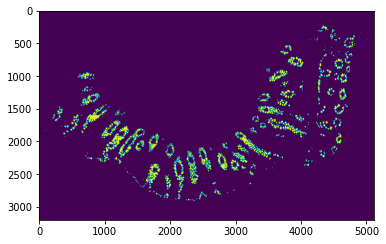

In [8]:
#上皮だけをclitした画像lamina_imgを生成
img=img[:detect_lamina.shape[0]*2, :detect_lamina.shape[1]*2,:]
detect_laminax2=detect_lamina.repeat(2, axis=0).repeat(2, axis=1)
detect_lamina3=np.stack([detect_laminax2,detect_laminax2,detect_laminax2], axis=-1).astype("uint8")
lamina_img=img*detect_lamina3

#杯細胞の検出
#laminaだけを取り出した画像をもとに、杯細胞を検出し、オーバーレイした状態で出力する
lamina_crop=lamina_img.reshape(int(lamina_img.shape[0]/height),height,int(lamina_img.shape[1]/width),width, 3)
lamina_crop=lamina_crop.transpose([0,2,1,3,4])
lamina_crop=lamina_crop.reshape(-1,height,width,3)
goblet_list=[]
for rgb in tqdm(lamina_crop):
  image = preprocessing_fn(rgb)
  image = image.transpose(2, 0, 1).astype('float32')
  image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
  predict = goblet_model(image)
  predict = predict.detach().cpu().numpy()[0]
  pr_goblet=predict[2,:,:]
  #確信度0.7以上を1とする
  pr_goblet = np.where(pr_goblet>0.7, 1, 0)
  goblet_list.append(pr_goblet)


goblet_arrays=np.stack(goblet_list)
goblet_arrays=goblet_arrays.reshape(int(lamina_img.shape[0]/height),int(lamina_img.shape[1]/width),height,width)
goblet_arrays=goblet_arrays.transpose([0,2,1,3])
goblet_arrays=goblet_arrays.reshape(int(lamina_img.shape[0]/height)*height, int(lamina_img.shape[1]/width)*width)

plt.imshow(goblet_arrays)

In [9]:
#detectした上皮細胞のドット数lamina_binsを数える
lamina_bins=np.bincount(detect_laminax2.astype("uint8").flatten())[1]
#detectした杯細胞のドット数goblet_binsを数える
goblet_bins=np.bincount(goblet_arrays.astype("uint8").flatten())[1]
#杯細胞と上皮細胞の比率を計算する
print("杯細胞と上皮細胞の比率{}".format(goblet_bins/lamina_bins))

杯細胞と上皮細胞の比率0.20671571966634772


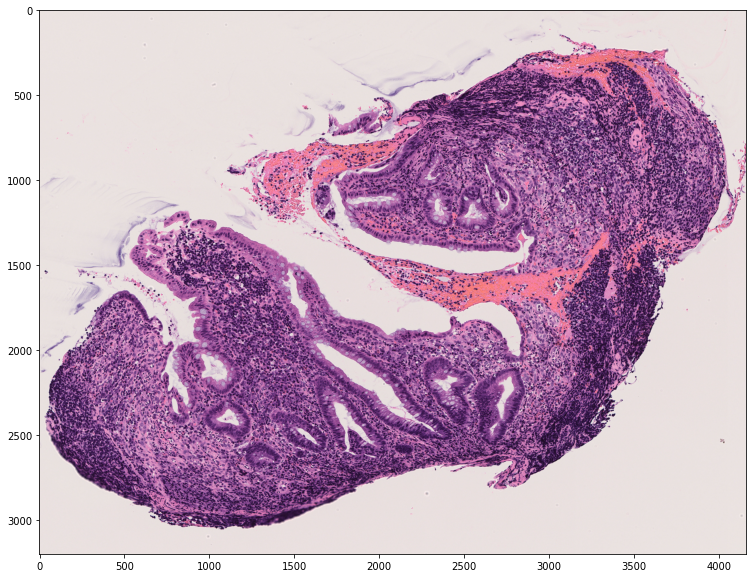

In [19]:
#今度は活動性のある検体
img_path='/content/gdrive/MyDrive/active_case.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=img[:3200, :4160,:]
plt.imshow(img)

100%|██████████| 30/30 [00:01<00:00, 15.93it/s]


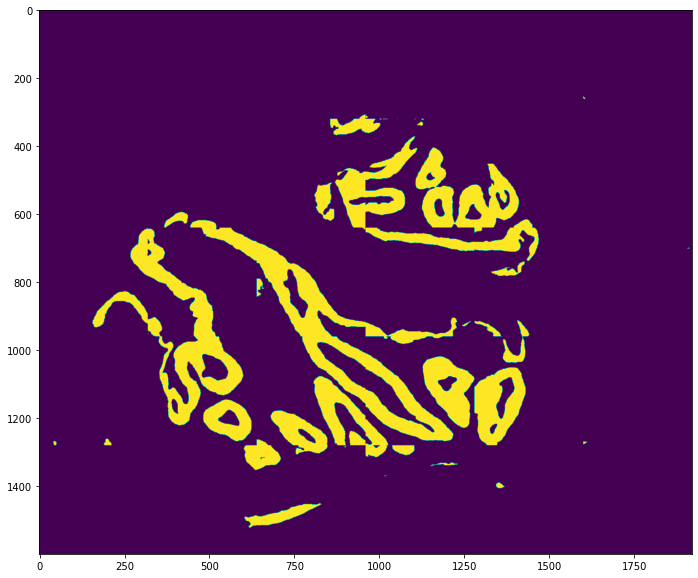

In [20]:
height = 320 #分割するタイルの高さ
width = 320 #分割するタイルの幅
img_half=resize(img, (img.shape[0] / 2, img.shape[1] / 2), anti_aliasing=True)
img_height= img_half.shape[0] #ロードした画像の高さ
img_width= img_half.shape[1] #}ロードした画像の幅
img_size=img_half.shape #ロードした画像のシェイプ
#画像を分割して一つのアレイcrop_arrayにまとめる
img_half=img_half[:int(img_size[0]/height)*height, :int(img_size[1]/width)*width,:]
crop_array=img_half.reshape(int(img_size[0]/height),height,int(img_size[1]/width),width, 3)
crop_array=crop_array.transpose([0,2,1,3,4])
crop_array=crop_array.reshape(-1,height,width,3)
lamina_list=[]
for rgb in tqdm(crop_array):
  # 前処理
    image = preprocessing_fn(rgb)
    image = image.transpose(2, 0, 1).astype('float32')
    image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predict = best_model(image)
    predict = predict.detach().cpu().numpy()[0]
    pr_lamina=predict[3,:,:]
    #確信度0.7以上を1とする
    pr_lamina = np.where(pr_lamina>0.7, 1, 0)
    lamina_list.append(pr_lamina)
lamina_arrays=np.stack(lamina_list)
#detect_arrayを並べて一つの画像に戻したdetect_img
re_x=lamina_arrays.reshape(int(img_size[0]/height),int(img_size[1]/width),height,width)
re_x=re_x.transpose([0,2,1,3])
detect_lamina=re_x.reshape(int(img_size[0]/height)*height, int(img_size[1]/width)*width).astype("uint8")
plt.imshow(detect_lamina)

100%|██████████| 120/120 [00:07<00:00, 16.66it/s]


杯細胞と上皮細胞の比率0.05222835521362028


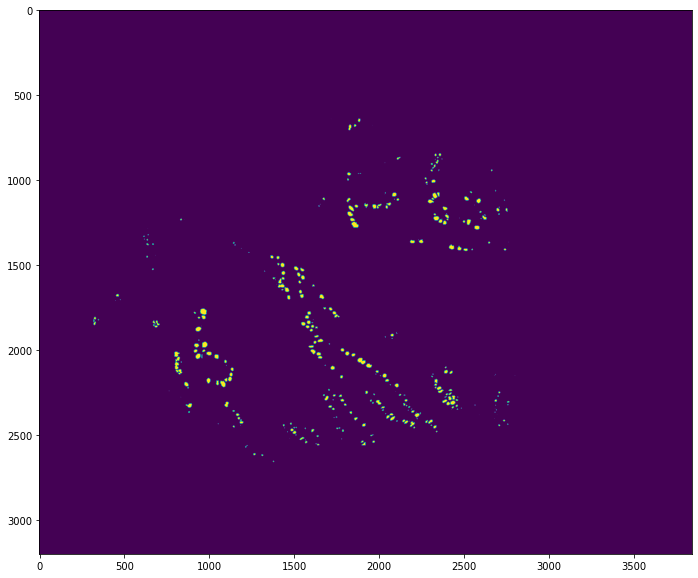

In [21]:
#上皮だけをclitした画像lamina_imgを生成
img=img[:detect_lamina.shape[0]*2, :detect_lamina.shape[1]*2,:]
detect_laminax2=detect_lamina.repeat(2, axis=0).repeat(2, axis=1)
detect_lamina3=np.stack([detect_laminax2,detect_laminax2,detect_laminax2], axis=-1).astype("uint8")
lamina_img=img*detect_lamina3

#杯細胞の検出
#laminaだけを取り出した画像をもとに、杯細胞を検出し、オーバーレイした状態で出力する
lamina_crop=lamina_img.reshape(int(lamina_img.shape[0]/height),height,int(lamina_img.shape[1]/width),width, 3)
lamina_crop=lamina_crop.transpose([0,2,1,3,4])
lamina_crop=lamina_crop.reshape(-1,height,width,3)
goblet_list=[]
for rgb in tqdm(lamina_crop):
  image = preprocessing_fn(rgb)
  image = image.transpose(2, 0, 1).astype('float32')
  image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
  predict = goblet_model(image)
  predict = predict.detach().cpu().numpy()[0]
  pr_goblet=predict[2,:,:]
  #確信度0.7以上を1とする
  pr_goblet = np.where(pr_goblet>0.7, 1, 0)
  goblet_list.append(pr_goblet)


goblet_arrays=np.stack(goblet_list)
goblet_arrays=goblet_arrays.reshape(int(lamina_img.shape[0]/height),int(lamina_img.shape[1]/width),height,width)
goblet_arrays=goblet_arrays.transpose([0,2,1,3])
goblet_arrays=goblet_arrays.reshape(int(lamina_img.shape[0]/height)*height, int(lamina_img.shape[1]/width)*width)

plt.imshow(goblet_arrays)
#detectした上皮細胞のドット数lamina_binsを数える
lamina_bins=np.bincount(detect_laminax2.astype("uint8").flatten())[1]
#detectした杯細胞のドット数goblet_binsを数える
goblet_bins=np.bincount(goblet_arrays.astype("uint8").flatten())[1]
#杯細胞と上皮細胞の比率を計算する
print("杯細胞と上皮細胞の比率{}".format(goblet_bins/lamina_bins))